# Llama 3 hosted on Groq + function calling + E2B Code interpreter        
**Powered by open-source [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)**

E2B's code interpreter SDK quickly creates a secure cloud sandbox powered by [Firecracker](https://github.com/firecracker-microvm/firecracker).

Inside this sandbox is a running Jupyter server that the LLM can use.

### Step 1: Install dependencies

We start by install the [E2B code interpreter SDK](https://github.com/e2b-dev/code-interpreter) and [Groq's Python SDK](https://console.groq.com/).

In [4]:
%pip install groq e2b_code_interpreter==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 937.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00


### Step 2: Define API keys, prompt, and tools

Let's define our variables with API keys for Groq and E2B together with the model ID, prompt, and our tools.

In [27]:
import os
import json
import re
import sys
import io
import contextlib
import warnings
from typing import Optional, List, Any, Tuple
from PIL import Image
from groq import Groq
from e2b_code_interpreter import Sandbox
from dotenv import load_dotenv


load_dotenv()


True

In [39]:
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
E2B_API_KEY = os.getenv('E2B_API_KEY')

In [72]:
# Or use 8b version
# MODEL_NAME = "llama3-8b-8192"
MODEL_NAME = "llama3-70b-8192"

SYSTEM_PROMPT = """you are a python data scientist. you are given tasks to complete and you run python code to solve them.
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment"""


tools = [
        {
            "type": "function",
            "function": {
                "name": "execute_python",
                "description": "Execute Python code generated by the 'explanation_problem' tool in a Streamlit app cell and return any result, stdout, stderr, display_data, and error.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "code": {
                            "type": "string",
                            "description": "The Python code to execute in a single cell."
                        }
                    },
                    "required": ["code"]
                }
            }
        },
        {
            "type": "function",
            "function": {
                "name": "explanation_problem",
                "description": "Based on the query or prompt provided by the user, generate the explanation and corresponding Python code to be executed by the 'execute_python' tool.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "userQuery": {
                            "type": "string",
                            "description": "Give a detailed explanation along with the executable code."
                        }
                    },
                    "required": ["userQuery"]
                }
            }
        }
    ]

### Step 3: Implement the method for code interpreting

Here's the main function that use the E2B code interpreter SDK. We'll be calling this function a little bit further when we're parsing the Llama's response with tool calls.

In [73]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.run_code(code,
  on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
  on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

### Step 4: Implement the method for calling LLM and parsing tools

Now we're going to define and implement `chat_with_llama` method. In this method, we'll call the LLM with our `tools` dictionary, parse the output, and call our `code_interpret` method we defined above.

In [74]:
import os
import json
import re
from groq import Groq

client = Groq(api_key=GROQ_API_KEY)

def chat_with_llama(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  response = client.chat.completions.create(
      model=MODEL_NAME,
      messages=messages,
      tools=tools,
      tool_choice="auto",
      max_tokens=4096,
  )

  response_message = response.choices[0].message
  tool_calls = response_message.tool_calls
  explanation = None
  if tool_calls:
    for tool_call in tool_calls:      
      function_name = tool_call.function.name
      function_args = json.loads(tool_call.function.arguments)
      if function_name == "execute_python":
        code = function_args["code"]
        code_interpreter_results = code_interpret(e2b_code_interpreter, code)        
      elif function_name == "explanation_problem":
        explanation = function_args["userQuery"]  
      else:
        raise Exception(f"Unknown tool {function_name}")
  else:
    print(f"(No tool call in model's response) {response_message}")
    return None, None, None
  return code_interpreter_results, explanation, response_message.content


### Step 5: Put everything together
In this last step, we put all the pieces together. We intantiate a new code interpreter instance using
```python
with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
```

and then call the `chat_with_llama` method with our user message and the `code_interpreter` instance.


User message: Visualize a distribution of height of men based on the latest data you know
Running code interpreter...


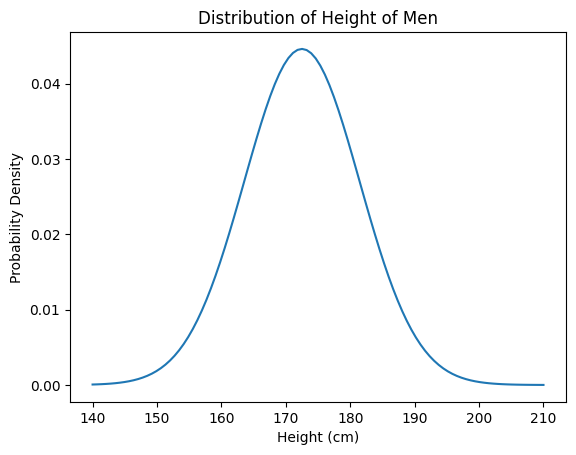

In [75]:
from e2b_code_interpreter import Sandbox
code_results, explanation, content = None, None, None
with Sandbox(api_key=E2B_API_KEY) as code_interpreter:
  code_results, explanation, content = chat_with_llama(
    code_interpreter,
    "Visualize a distribution of height of men based on the latest data you know"
  )
  if code_results:
    first_result = code_results[0]
  else:
    print("No code results")
    exit(0)


# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result#, explanation, content

In [76]:
explanation

In [77]:
content

#### Creating common funtion

In [13]:
from e2b_code_interpreter import Sandbox

In [28]:
def upload_dataset(code_interpreter: Sandbox, uploaded_file) -> str:
    dataset_path = 'final_dataset.csv'#f"./{uploaded_file.name}"
    
    try:
        code_interpreter.files.write(dataset_path, uploaded_file)
        return dataset_path
    except Exception as error:
        print(f"Error during file upload: {error}")
        raise error

In [34]:
def code_executor(e2b_code_interpreter, user_message, dataset_path):
  MODEL_NAME = "llama3-70b-8192"
  client = Groq(api_key=GROQ_API_KEY)
  SYSTEM_PROMPT = f"""You're a Python data scientist and data visualization expert. You are given a dataset at path '{dataset_path}' and also the user's query.
        You need to analyze the dataset and answer the user's query with a response and you run Python code to solve them.
        - the python code runs in jupyter notebook as well as in a streamlit app.
        - every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
        - display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
        - you have access to the internet and can make api requests.
        - you also have access to the filesystem and can read/write files.
        - you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
        - you can run any python code you want, everything is running in a secure sandbox environment
        IMPORTANT: Always use the dataset path variable '{dataset_path}' in your code when reading the CSV file."""

  tools = [
    {
      "type": "function",
        "function": {
          "name": "execute_python",
          "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
          "parameters": {
            "type": "object",
            "properties": {
              "code": {
                "type": "string",
                "description": "The python code to execute in a single cell.",
              }
            },
            "required": ["code"],
          },
        },
    }
  ]
  def code_interpret(e2b_code_interpreter, code):
    print("Running code interpreter...")
    exec = e2b_code_interpreter.run_code(code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout))
    if exec.error:
      print("[Code Interpreter ERROR]", exec.error)
    else:
      return exec.results

  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  response = client.chat.completions.create(
      model=MODEL_NAME,
      messages=messages,
      tools=tools,
      tool_choice="auto",
      max_tokens=4096,
  )

  response_message = response.choices[0].message
  tool_calls = response_message.tool_calls

  if tool_calls:
    for tool_call in tool_calls:
      function_name = tool_call.function.name
      function_args = json.loads(tool_call.function.arguments)
      if function_name == "execute_python":
        code = function_args["code"]
        code_interpreter_results = code_interpret(e2b_code_interpreter, code)
        return code_interpreter_results, response_message.content
      else:
        raise Exception(f"Unknown tool {function_name}")
        return None,response_message.content
  else:
    print(f"(No tool call in model's response) {response_message}")
    return None, response_message.content